In [1]:
# Importació de llibreries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
import plotly.io as pio

# Preprocessament
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import IsolationForest

# Models
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Carregar dades
file = "Conjunt de dades Preprocessades/Datasets/Amazon_Stock_Price_output.csv"
data = pd.read_csv(file)

# Paràmetres
features = ["Open","High","Low","Volume","EMA_7","EMA_40",
            "MACD","Signal_Line","MACD_Hist","RSI","ATR"]
target_col = "Close"
SEQ_LENGTH = 30  # seqüència de 30 dies

# 1. Normalitzar TOT el dataset (per poder aplicar després seqüències a tota la data)
feature_scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = data.copy()
data_scaled[features] = feature_scaler.fit_transform(data[features])

# Funció per crear seqüències
def create_sequences(data, seq_length, target_col='Close'):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)
        y.append(data.iloc[i+seq_length][target_col])
    return np.array(X), np.array(y)

# 2. Crear seqüències sobre el dataset normalitzat
X_all, y_all = create_sequences(data_scaled, SEQ_LENGTH, target_col)

# 3. Dividir en train, val i test mantenint l'ordre temporal
total_samples = X_all.shape[0]
train_end = int(total_samples * 0.7)
val_end = train_end + int(total_samples * 0.15)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

print("Formes dels conjunts:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Train X: (998, 30, 11)
Train y: (998, 1)
Test  X: (250, 30, 11)
Test  y: (250, 1)


In [4]:
# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def build_regularized_lstm_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.3, learning_rate=0.001, l2_reg=0.001):
    """
    Model LSTM amb regularització L2 i més Dropout per evitar sobreentrenament
    """
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape,
             kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        LSTM(lstm_units // 2, kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


# Inicialitzar LSTM model
lstm_model = build_regularized_lstm_model((SEQ_LENGTH, X_train.shape[2]))

lstm_model.summary()

c:\Users\jesus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,345 (130.25 KB)

 Trainable params: 33,153 (129.50 KB)

 Non-trainable params: 192 (768.00 B)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reentrenar amb model nou
lstm_model = build_regularized_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_regularized_lstm_model.keras', save_best_only=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,  # pots pujar si vols
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)



NameError: name 'X_val' is not defined

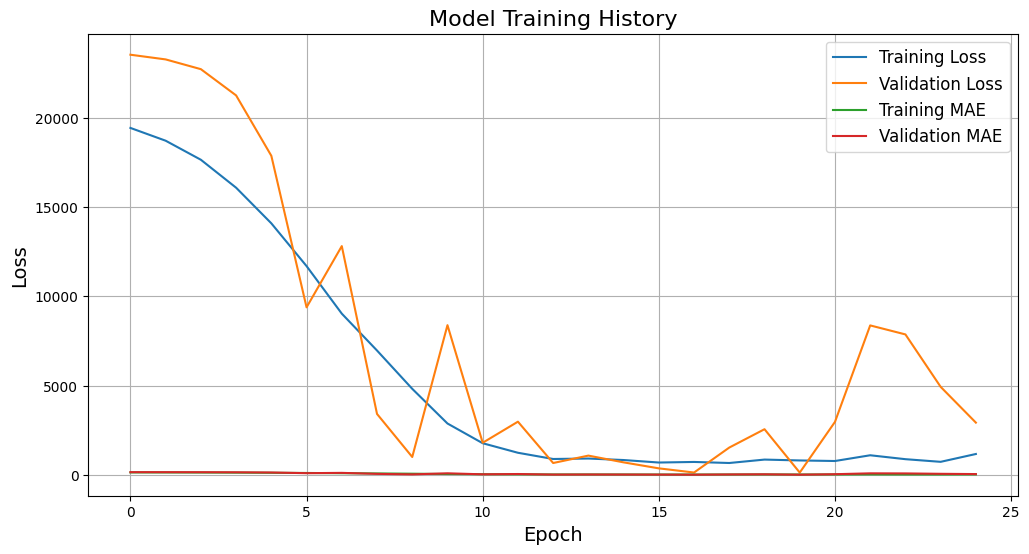

In [5]:
# Representació gràfica de l'historial d'entrenament
def plot_training_history(history):
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    
    plt.title('Model Training History', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_training_history(history)




In [6]:

# Prediccions LSTM sobre train i càlcul de residus
y_pred_lstm_train = lstm_model.predict(X_train).flatten()
residuals_train = y_train - y_pred_lstm_train

# Preparar dades per a XGBoost (reshape 3D -> 2D)
xgb_X_train = X_train.reshape(X_train.shape[0], -1)

# Entrenar XGBoost per predir residus
xgb_residual_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_residual_model.fit(xgb_X_train, residuals_train)

# Prediccions híbrides sobre dades de test
# Predicció LSTM
y_pred_lstm_test = lstm_model.predict(X_test).flatten()

# Preparar dades test per XGBoost
xgb_X_test = X_test.reshape(X_test.shape[0], -1)

# Predicció residus amb XGBoost
residuals_pred_test = xgb_residual_model.predict(xgb_X_test)

# Predicció final suma LSTM + residus XGBoost
y_pred_hybrid = y_pred_lstm_test + residuals_pred_test

# Avaluar el model híbrid
mse = mean_squared_error(y_test, y_pred_hybrid)
mae = mean_absolute_error(y_test, y_pred_hybrid)

print(f"Model híbrid LSTM + XGBoost — MSE: {mse:.5f}, MAE: {mae:.5f}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Model híbrid LSTM + XGBoost — MSE: 605.08243, MAE: 20.71448


In [7]:
# Funció per avaluar models amb diverses mètriques
def evaluate_models(y_true, y_pred_lstm_test, y_pred_hybrid):

    results = []
    
    def calculate_metrics(y_true, y_pred, model_name):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        return {
            "Model": model_name,
            "MSE": round(mse, 6),
            "MAE": round(mae, 6),
            "R² Score": round(r2, 4)
        }
    
    results.append(calculate_metrics(y_true, y_pred_lstm_test, "LSTM"))
    results.append(calculate_metrics(y_true, y_pred_hybrid, "Hybrid"))
    
    return pd.DataFrame(results)

results_df = evaluate_models(y_test, y_pred_lstm_test, y_pred_hybrid)

print("Model Performance Comparison:")
display(results_df)

Model Performance Comparison:


,Model,MSE,MAE,R² Score
0,LSTM,460.215196,15.814664,-0.3016
1,Hybrid,605.082434,20.714481,-0.7113


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Suposem que tens aquestes variables de predicció sobre test:
# y_test           -> valors reals (test)
# y_pred_lstm_test -> prediccions LSTM
# y_pred_hybrid    -> prediccions híbrid (LSTM + XGBoost)

def evaluate_test_set(y_true, y_pred_lstm, y_pred_hybrid):
    results = []
    
    def calc_metrics(y_true, y_pred, model_name):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return {
            "Model": model_name,
            "MSE": round(mse, 6),
            "MAE": round(mae, 6),
            "R2_Score": round(r2, 4)
        }
    
    results.append(calc_metrics(y_true, y_pred_lstm, "LSTM"))
    results.append(calc_metrics(y_true, y_pred_hybrid, "Híbrid"))
    
    return pd.DataFrame(results)

# Calcular les mètriques sobre test
test_metrics_df = evaluate_test_set(y_test, y_pred_lstm_test, y_pred_hybrid)

print("Mètriques sobre el conjunt Test:")
display(test_metrics_df)


Mètriques sobre el conjunt Test:


,Model,MSE,MAE,R2_Score
0,LSTM,460.215196,15.814664,-0.3016
1,Híbrid,605.082434,20.714481,-0.7113


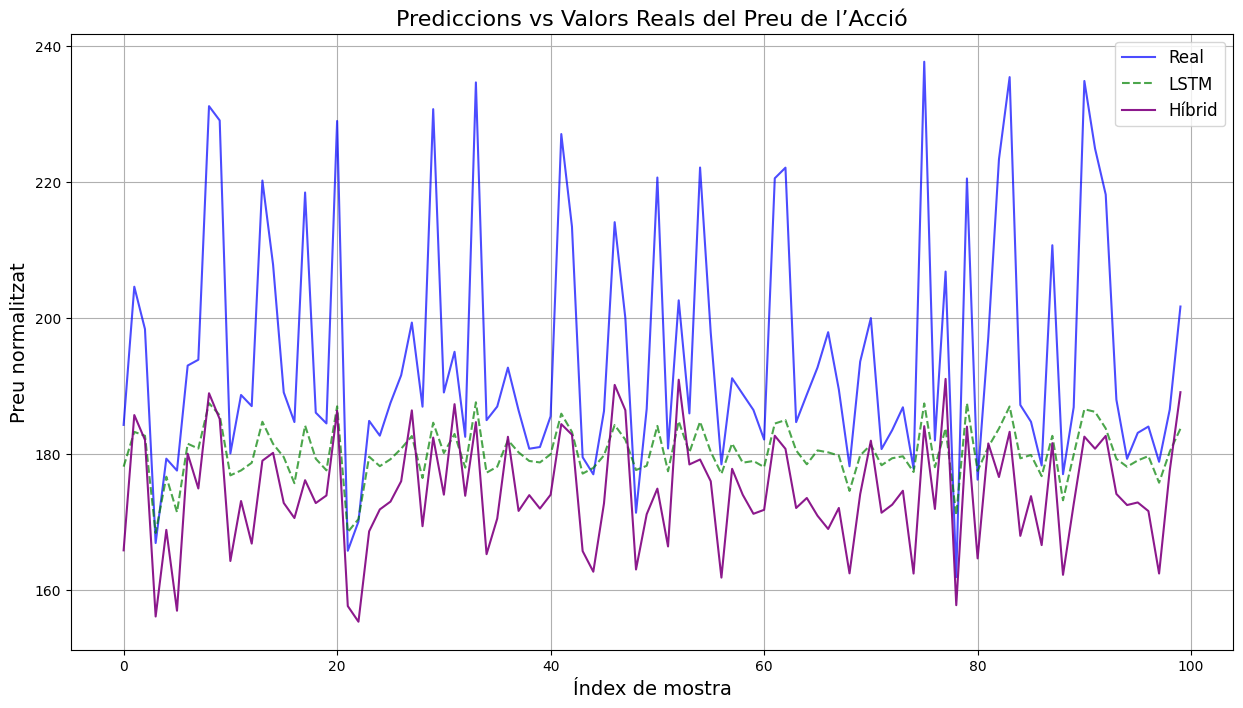

In [9]:
def plot_predictions(y_true, y_pred_lstm_test, y_pred_hybrid, n_samples=100):
    
    plt.figure(figsize=(15, 8))
    
    # Selecciona un subconjunt per visualitzar més clarament
    idx = np.random.choice(len(y_true), size=min(n_samples, len(y_true)), replace=False)
    
    plt.plot(y_true[idx], label='Real', color='blue', alpha=0.7)
    plt.plot(y_pred_lstm_test[idx], label='LSTM', color='green', linestyle='--', alpha=0.7)
    plt.plot(y_pred_hybrid[idx], label='Híbrid', color='purple', linestyle='-', alpha=0.9)
    
    plt.title('Prediccions vs Valors Reals del Preu de l’Acció', fontsize=16)
    plt.xlabel('Índex de mostra', fontsize=14)
    plt.ylabel('Preu normalitzat', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_predictions(y_test, y_pred_lstm_test, y_pred_hybrid)


In [10]:
def inverse_transform_predictions(preds, scaler):
    # Reshape per fer la transformació inversa
    preds_2d = preds.reshape(-1, 1)
    dummy = np.zeros((len(preds_2d), len(scaler.feature_names_in_)))
    
    # Posar les prediccions a la columna 'Close'
    close_idx = list(scaler.feature_names_in_).index('Close')
    dummy[:, close_idx] = preds_2d.flatten()
    
    # Fer la transformació inversa
    original_scale = scaler.inverse_transform(dummy)[:, close_idx]
    
    return original_scale

# Obtenir preus reals i preus predits en escala original
actual_prices = inverse_transform_predictions(y_test, feature_scaler)
hybrid_prices = inverse_transform_predictions(y_pred_hybrid, feature_scaler)

# Representar gràficament
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Preu Real', color='blue')
plt.plot(hybrid_prices, label='Preu Previst (Híbrid)', color='red', linestyle='--')
plt.title('Preus Reals vs Predits (Escala Original)', fontsize=16)
plt.xlabel('Instants de Temps', fontsize=14)
plt.ylabel('Preu ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


ValueError: 'Close' is not in list

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Crear figura amb Plotly
fig = go.Figure()

# Afegir línia per als valors reals
fig.add_trace(go.Scatter(
    x=data['Date'].iloc[-len(actual_prices):], 
    y=actual_prices, 
    mode='lines', 
    name='Preu real (Close)', 
    line=dict(color='blue')
))

# Afegir línia per als valors predits del model híbrid
fig.add_trace(go.Scatter(
    x=data['Date'].iloc[-len(hybrid_prices):], 
    y=hybrid_prices, 
    mode='lines', 
    name='Predicció híbrida', 
    line=dict(color='red', dash='dash')
))

# Configuració del gràfic
fig.update_layout(
    title='Predicció del Preu de les Accions (Amazon)',
    xaxis_title='Data',
    yaxis_title='Preu de l\'acció (USD)',
    template='plotly_dark',
    xaxis_rangeslider_visible=True
)

pio.renderers.default = 'browser'
fig.show()


In [ ]:
future_preds_scaled = []
sequence = X_test[-1].copy()  
future_dates = []
last_date = data.iloc[-1]["Date"] 

for i in range(10):
    # Predicció LSTM (en escala normalitzada)
    pred_lstm = lstm_model.predict(sequence.reshape(1, sequence.shape[0], sequence.shape[1])).flatten()[0]

    # Predicció del residu amb XGBoost (també escala normalitzada)
    xgb_input = sequence.reshape(1, -1)
    pred_residual = xgb_residual_model.predict(xgb_input)[0]

    # Combinació final (en escala normalitzada)
    pred_final_scaled = pred_lstm + pred_residual
    future_preds_scaled.append(pred_final_scaled)

    # Actualitza la seqüència
    new_step = sequence[-1].copy()
    new_step[0] = pred_final_scaled  
    sequence = np.vstack([sequence[1:], new_step])
    
    # Guardar la predicció i la data
    next_day_date = pd.to_datetime(last_date) + pd.Timedelta(days=i + 1)
    future_dates.append(next_day_date.strftime('%Y-%m-%d'))

# Desescalat final
future_preds_original = inverse_transform_predictions(np.array(future_preds_scaled), feature_scaler)

# Resultat
print("Prediccions en escala original:")
for i, val in enumerate(future_preds_original, 1):
    print(f"Dia {i}: {val:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediccions en escala original:
Dia 1: 4736.01
Dia 2: 4540.38
Dia 3: 4522.79
Dia 4: 4682.07
Dia 5: 4607.31
Dia 6: 4647.99
Dia 7: 4768.90
Dia 8: 4718.10
Dia 9: 4700.13
Dia 10: 4661.51


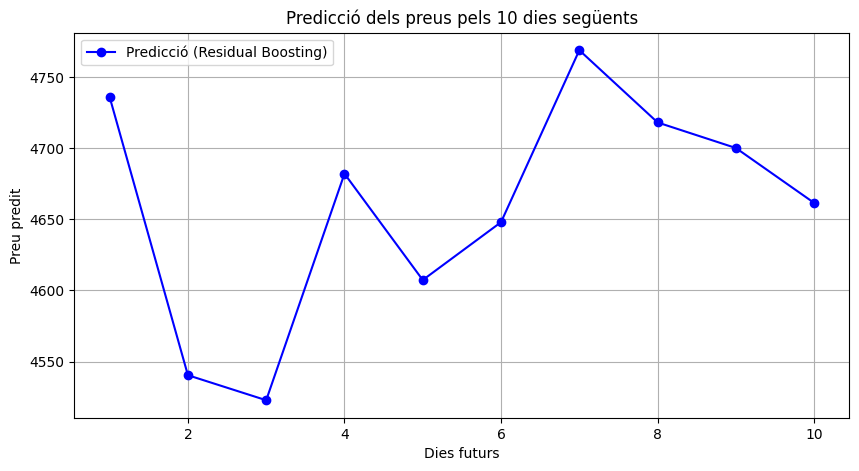

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), future_preds_original, marker='o', linestyle='-', color='blue', label='Predicció (Residual Boosting)')
plt.title('Predicció dels preus pels 10 dies següents')
plt.xlabel('Dies futurs')
plt.ylabel('Preu predit')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
## --- GRÀFIC DE PREDICCIÓ FUTURA ---
future_dates_dt = pd.to_datetime(future_dates)

fig_future = go.Figure()

# Històric
fig_future.add_trace(go.Scatter(
    x=data['Date'].iloc[-len(actual_prices):], 
    y=actual_prices, 
    mode='lines', 
    name='Preu real (Close)', 
    line=dict(color='blue')
))
# Prediccions futures
fig_future.add_trace(go.Scatter(
    x=future_dates_dt, 
    y=np.array(future_preds_original), 
    mode='lines+markers',
    name='Predicció futura', 
    line=dict(color='orange', dash='dash'),
    text=[f"{p:.2f}" for p in future_preds_original],
    textposition="top center"
))

fig_future.update_layout(
    title='Predicció dels propers 10 dies (Amazon)',
    xaxis_title='Data',
    yaxis_title='Preu Acció (USD)',
    template='plotly_dark',
    xaxis_rangeslider_visible=True
)

fig_future.show()
